### Description
This notebook demonstrates an inconsistency with the findings of Dutton et al. 2011 Appendix A (MNRAS 417 1621). Following the prescription given, a Chameleon profile should match a Sersic closely within several effective radii. Here I plot a Sersic profile and the corresponding Chameleon profile both using lenstronomy and manually. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import sys
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Util import param_util


kwargs_sersic:  {'k_eff': 0.9, 'R_sersic': 2, 'n_sersic': 4, 'e1': 0.0, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
kwargs_chameleon:  {'alpha_1': array(8.3074124), 'w_c': 0.021319648524401356, 'w_t': 1.635700643882536, 'e1': 0.0, 'e2': 0.0, 'center_x': 0, 'center_y': 0}

Compare following 3 values with Fig. A1 (n=4):
log10(sig0/sersic):  -0.8718201259999998
log10(R0/sersic):  1.5667616249999998
log10(alpha):  -1.8849237840000002


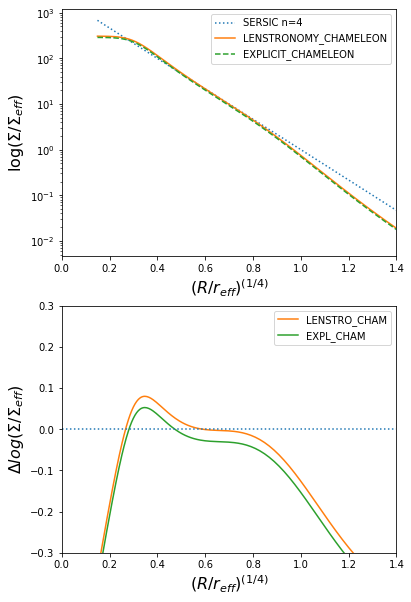

In [2]:
#Sersic lens params
r_eff=2 #arcsec
kappa_eff=0.9
n_sersic=4   
q_lens=1
e1,e2=param_util.phi_q2_ellipticity(0,q_lens)

f,prof_ax=plt.subplots(2, 1, figsize=(6, 10))
plot_radius=np.logspace(-3, 1, 200)

#create Sersic profile
if n_sersic==4:
    b_n=7.66925
else:
    sys.exit('Error: n_sersic not supported')
kwargs_sersic={'k_eff':kappa_eff, 'R_sersic':r_eff, 'n_sersic':n_sersic, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}
print('kwargs_sersic: ', kwargs_sersic)
lens_model_list=['SERSIC_ELLIPSE_KAPPA']
Lens = LensModel(lens_model_list=lens_model_list)
LensAn_sersic= LensProfileAnalysis(Lens)
defl_1=Lens.alpha(1/np.sqrt(q_lens),0,[kwargs_sersic])[0] #deflection at 1" used as normalization for lenstronomy Chameleon
plot_kappa_sersic=LensAn_sersic.radial_lens_profile(plot_radius, [kwargs_sersic], center_x=0,center_y=0)
scaled_sigma_sersic=np.array(plot_kappa_sersic)/kappa_eff


#Chameleon params
#from Dutton et al. 2011, calculate desired conversion from sersic using polynomial from Eq. A9 and Table A1
def sersic2cham_sig0(sigma_0_sersic,n):
    x0=1.69
    y0=-0.254
    y1=-0.259
    y2=-0.036
    y3=0.014
    y=y0+y1*(n-x0)+y2*(n-x0)**2+y3*(n-x0)**3
    return sigma_0_sersic*10**y
def sersic2cham_R0(R0_sersic,n):
    x0=1.15
    y0=0.078
    y1=-0.184
    y2=0.473
    y3=-0.079
    y=y0+y1*(n-x0)+y2*(n-x0)**2+y3*(n-x0)**3
    return R0_sersic*10**y
def sersic2cham_alpha(n):
    x0=2.03
    y0=-0.739
    y1=-0.527
    y2=-0.012
    y3=-0.008
    y=y0+y1*(n-x0)+y2*(n-x0)**2+y3*(n-x0)**3
    return 10**y
R0_sersic=r_eff/(b_n**n_sersic)
sig0_sersic=kappa_eff/np.exp(-b_n)
dutton_sig0=sersic2cham_sig0(sig0_sersic,n_sersic)
dutton_R0=sersic2cham_R0(R0_sersic,n_sersic)
dutton_alpha=sersic2cham_alpha(n_sersic)

#Convert to lenstronomy (Suyu et al. 2014) notation. Use Sersic deflection as normalization
kwargs_chameleon={'alpha_1':defl_1, 'w_c':dutton_R0, 'w_t':dutton_R0/dutton_alpha, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}
print('kwargs_chameleon: ', kwargs_chameleon)
print()
print('Compare following 3 values with Fig. A1 (n=4):')
print('log10(sig0/sersic): ', np.log10(dutton_sig0/(sig0_sersic)))
print('log10(R0/sersic): ', np.log10((dutton_R0/R0_sersic)))
print('log10(alpha): ', np.log10(dutton_alpha))
lens_model_list=['CHAMELEON']
Lens = LensModel(lens_model_list=lens_model_list)
LensAn= LensProfileAnalysis(Lens)
plot_kappa_cham=LensAn.radial_lens_profile(plot_radius, [kwargs_chameleon], center_x=0,center_y=0)
scaled_sigma_cham=np.array(plot_kappa_cham)/kappa_eff

#also plot explicit equation from Dutton et al.
def explicit_cham(r,sigma0,r0,alpha):
    r2=r0/alpha
    return sigma0/(1-alpha)*(r0/np.sqrt(r**2+r0**2)-r0/np.sqrt(r**2+r2**2))
plot_expl_cham=explicit_cham(plot_radius,dutton_sig0,dutton_R0,dutton_alpha)
scaled_sigma_expl_cham=np.array(plot_expl_cham)/kappa_eff

prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_sersic,linestyle=':',label='SERSIC n=4')
prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_cham,label='LENSTRONOMY_CHAMELEON')
prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_expl_cham,linestyle='--',label='EXPLICIT_CHAMELEON')
prof_ax[0].legend()
prof_ax[0].set_ylabel(r'log($\Sigma/\Sigma_{eff})$',fontsize=16)

prof_ax[1].plot((plot_radius/r_eff)**(1/4),(np.log10(scaled_sigma_cham)-np.log10(scaled_sigma_sersic)),color='C1',label='LENSTRO_CHAM')
prof_ax[1].plot((plot_radius/r_eff)**(1/4),(np.log10(scaled_sigma_expl_cham)-np.log10(scaled_sigma_sersic)),color='C2',label='EXPL_CHAM')

prof_ax[1].set_ylabel(r'$\Delta log(\Sigma/\Sigma_{eff})$',fontsize=16)
prof_ax[1].set_ylim(-0.3,0.3)
prof_ax[1].axhline(y=0,xmin=0,xmax=1,color='C0',linestyle=':')
prof_ax[1].legend()
for axi in [0,1]:
    prof_ax[axi].set_xlim(0,1.4)
    prof_ax[axi].set_xlabel(r'$(R/r_{eff})^{(1/4)}$',fontsize=16)


### The above figure does not match, dropping too low near R=r_eff.
The above graph should be compared to Fig A2 of Dutton et al. 2011, for n=4 (bottom left). 


Note that my two Chameleon profiles have different normalization depending on if I use the deflection of the original Sersic in lenstronomy (yellow) or the sigma0 from Dutton et al. (green). Regardless, the shape is the same and does not match Dutton et al.



### Next, I try a modification

Next cell is the same as above, but reducing alpha by a factor of 1.5. This is an increase in w_t by the same factor in the lenstronomy (Suyu et al. 2014) notation



kwargs_chameleon:  {'alpha_1': array(8.3074124), 'w_c': 0.021319648524401356, 'w_t': 2.4535509658238044, 'e1': 0.0, 'e2': 0.0, 'center_x': 0, 'center_y': 0}

Compare following 3 values with Fig. A1 (n=4):
log10(sig0/sersic):  -0.8718201259999998
log10(R0/sersic):  1.5667616249999998
log10(alpha):  -2.0610150430556815
note that alpha no longer matches


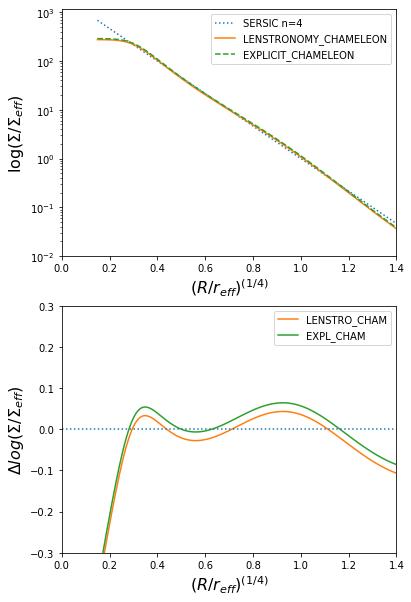

In [3]:
modified_alpha=dutton_alpha/1.5

f,prof_ax=plt.subplots(2, 1, figsize=(6, 10))

kwargs_chameleon={'alpha_1':defl_1, 'w_c':dutton_R0, 'w_t':dutton_R0/modified_alpha, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}
print('kwargs_chameleon: ', kwargs_chameleon)
print()
print('Compare following 3 values with Fig. A1 (n=4):')
print('log10(sig0/sersic): ', np.log10(dutton_sig0/(sig0_sersic)))
print('log10(R0/sersic): ', np.log10((dutton_R0/R0_sersic)))
print('log10(alpha): ', np.log10(modified_alpha))
print('note that alpha no longer matches')
lens_model_list=['CHAMELEON']
Lens = LensModel(lens_model_list=lens_model_list)
LensAn= LensProfileAnalysis(Lens)
plot_kappa_cham=LensAn.radial_lens_profile(plot_radius, [kwargs_chameleon], center_x=0,center_y=0)
scaled_sigma_cham=np.array(plot_kappa_cham)/kappa_eff
#also plot explicit equation from Dutton et al.
def explicit_cham(r,sigma0,r0,alpha):
    r2=r0/alpha
    return sigma0/(1-alpha)*(r0/np.sqrt(r**2+r0**2)-r0/np.sqrt(r**2+r2**2))
plot_expl_cham=explicit_cham(plot_radius,dutton_sig0,dutton_R0,modified_alpha)
scaled_sigma_expl_cham=np.array(plot_expl_cham)/kappa_eff

prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_sersic,linestyle=':',label='SERSIC n=4')
prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_cham,label='LENSTRONOMY_CHAMELEON')
prof_ax[0].semilogy((plot_radius/r_eff)**(1/4),scaled_sigma_expl_cham,linestyle='--',label='EXPLICIT_CHAMELEON')
prof_ax[0].legend()
prof_ax[0].set_ylabel(r'log($\Sigma/\Sigma_{eff})$',fontsize=16)

prof_ax[1].plot((plot_radius/r_eff)**(1/4),(np.log10(scaled_sigma_cham)-np.log10(scaled_sigma_sersic)),color='C1',label='LENSTRO_CHAM')
prof_ax[1].plot((plot_radius/r_eff)**(1/4),(np.log10(scaled_sigma_expl_cham)-np.log10(scaled_sigma_sersic)),color='C2',label='EXPL_CHAM')

prof_ax[1].set_ylabel(r'$\Delta log(\Sigma/\Sigma_{eff})$',fontsize=16)
prof_ax[1].set_ylim(-0.3,0.3)
prof_ax[1].axhline(y=0,xmin=0,xmax=1,color='C0',linestyle=':')
prof_ax[1].legend()
for axi in [0,1]:
    prof_ax[axi].set_xlim(0,1.4)
    prof_ax[axi].set_xlabel(r'$(R/r_{eff})^{(1/4)}$',fontsize=16)


#### The figure now matches Dutton et al 2011
Although the new smaller alpha value no longer matches Figure A1. 

##### In conclusion, a smaller alpha (larger w_t) is necessary to match the Sersic profile to the prescribed level, which requires breaking from the formula provided